In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121

import tensorflow_hub as hub
import tensorflow as tf
import sklearn
from classification_models.keras import Classifiers

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [3]:
def create_resnet18_model(image_size):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    # base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [4]:
IMAGE_SIZE = 224
IMAGE_CENTER = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)

def normalize_image(img, label):
    img = tf.cast(img, np.float32)# / 255.0
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [5]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None)) 
    
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [12]:
test_df = pd.read_csv('balancing/3333Finding10kNofinding.csv')
images_test, labels_test = prepare_data(test_df, IMAGE_SIZE)
with open(f"balancing/3333Finding10kNofinding.pkl", "wb") as file:
    pickle.dump((images_test, labels_test), file)
    
with open(f"balancing/3333Finding10kNofinding.pkl", "rb") as file:
    images_test, labels_test = pickle.load(file)
pass

100%|██████████| 19999/19999 [03:17<00:00, 101.28it/s]


In [14]:
master_evaluations = {}
BATCH_SIZE = 16
IMAGE_SIZE = 224

with open(f"balancing/testing.pkl", "rb") as file:
    images_test, labels_test = pickle.load(file)


# for aug_idx in [0, 1, 2, 3, 4]:
for bal_idx in [2, 1, 0]:
    
    evaluations = {}
    
    images = None
    labels = None
    if bal_idx == 2:
        with open(f"balancing/5keach.pkl", "rb") as file:
            images, labels = pickle.load(file)
    if bal_idx == 1:
        with open(f"balancing/3333Finding10kNofinding.pkl", "rb") as file:
            images, labels = pickle.load(file)
    if bal_idx == 0:
        with open(f"augmentation_data/images_clean_20000.pkl", "rb") as file:
            images = pickle.load(file)
        with open(f"augmentation_data/labels_clean_20000.pkl", "rb") as file:
            labels = pickle.load(file)
    
    for run in range(5):
    
        tf.keras.backend.clear_session()
           
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        # images, labels = prepare_data(df, IMAGE_SIZE)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2, stratify=labels)
            
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
        model = create_resnet18_model(IMAGE_SIZE)
                            
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping]) #######BIRNE
        
        sub_eval = evaluate_model(model, images_test, labels_test)
        
        evaluations[run] = sub_eval
        print(bal_idx)
        print(evaluations)
        
    master_evaluations[bal_idx] = evaluations

2025-04-03 13:48:52.897866: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-03 13:48:52.898084: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-03 13:48:52.898788: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1743680932.899296 6767168 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743680932.900002 6767168 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-04-03 13:49:04.692655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 56ms/step - auc: 0.6471 - loss: 1.4762 - val_auc: 0.7197 - val_loss: 1.2544
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - auc: 0.7213 - loss: 1.2100 - val_auc: 0.7257 - val_loss: 1.2199
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.7425 - loss: 1.1737 - val_auc: 0.7341 - val_loss: 1.2044
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - auc: 0.7599 - loss: 1.1390 - val_auc: 0.7282 - val_loss: 1.2797
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - auc: 0.7781 - loss: 1.1018 - val_auc: 0.7387 - val_loss: 1.1918
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - auc: 0.7968 - loss: 1.0624 - val_auc: 0.7416 - val_loss: 1.1884
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - auc: 0.8166 - loss: 1.0150 - val_auc: 0.7357 - val_loss: 1.2452
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - auc: 0.8335 - loss: 0.9713 - val_auc: 0.7361 - val_loss: 1.2620
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━

In [2]:
evaluations_original = {0: ([0.7555346882154066, 0.794719225867483, 0.5810687520671096, 0.6944914188282647], 0.25847951805012215, 0.6895), 1: ([0.752866363953365, 0.8025195109773882, 0.585957936197721, 0.6890460783765653], 0.2568474331532784, 0.68975), 2: ([0.7488117618520596, 0.79049841678601, 0.5781813757178508, 0.6872035955202743], 0.2691677947808307, 0.6875), 3: ([0.7383668263618309, 0.7911939469984627, 0.5783645968008659, 0.685570022501118], 0.25815125289943996, 0.689), 4: ([0.748684789035613, 0.7901182155010444, 0.5861294123395171, 0.6881262927661003], 0.26744817805221477, 0.68925)}

evaluations_3_10 = {0: ([0.7342856926272382, 0.8246056746068243, 0.6019211905048257, 0.6982145269640727], 0.3649495935070578, 0.66475), 1: ([0.7416719098227688, 0.8157009170816308, 0.6017093117652365, 0.6943630157088552], 0.35063759927775134, 0.66325), 2: ([0.7312440303825104, 0.8189116881922456, 0.5993250886977961, 0.6919399527616279], 0.3658183282730403, 0.6605), 3: ([0.7283369214208827, 0.8051415038562101, 0.5960717399801558, 0.6823202006932021], 0.32715783177894364, 0.671), 4: ([0.723121560363256, 0.7998761677024346, 0.5867988739889954, 0.6828949575134168], 0.3475005836079873, 0.65475)}


evaluations_equally = {0: ([0.7150910035021757, 0.779980883183771, 0.5621612758952463, 0.6782048952742994], 0.41689802162613565, 0.51275), 1: ([0.7047247153534772, 0.7970809081473111, 0.5791533870531285, 0.6802546865682766], 0.41351440073139023, 0.54975), 2: ([0.7173774617565457, 0.7977961464177319, 0.5820074077693256, 0.6848038256559332], 0.4103987617501188, 0.5005), 3: ([0.7384160993950789, 0.7993358384464796, 0.5760752728584744, 0.6909630990980918], 0.40809536122042933, 0.5195), 4: ([0.7249645613183947, 0.7907907529792015, 0.5782208387203464, 0.6872603724098092], 0.4302744939142857, 0.52825)}


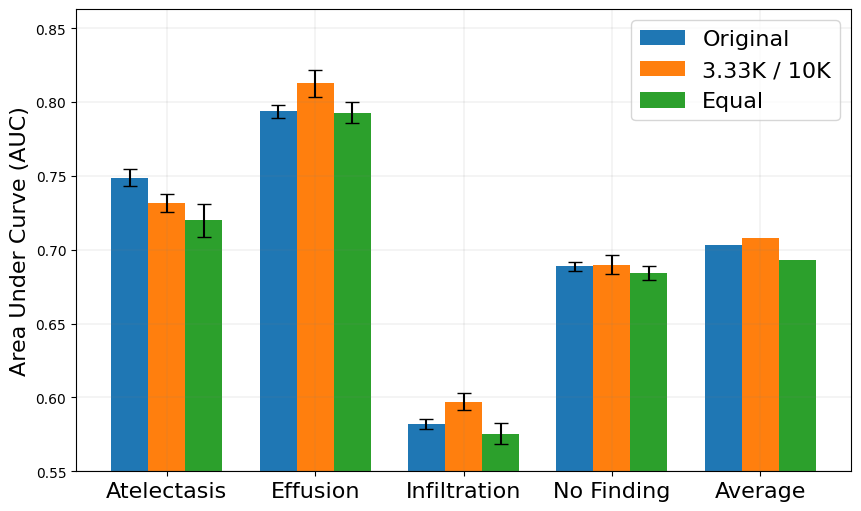

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_at.append(eval[0][0])
    original_ef.append(eval[0][1])
    original_in.append(eval[0][2])
    original_nf.append(eval[0][3])
original_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}
original_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [original_at, original_ef, original_in, original_nf])}

horizontal_at, horizontal_ef, horizontal_in, horizontal_nf = [], [], [], []
for eval in evaluations_3_10.values():
    horizontal_at.append(eval[0][0])
    horizontal_ef.append(eval[0][1])
    horizontal_in.append(eval[0][2])
    horizontal_nf.append(eval[0][3])
horizontal_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}
horizontal_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [horizontal_at, horizontal_ef, horizontal_in, horizontal_nf])}

translation_at, translation_ef, translation_in, translation_nf = [], [], [], []
for eval in evaluations_equally.values():
    translation_at.append(eval[0][0])
    translation_ef.append(eval[0][1])
    translation_in.append(eval[0][2])
    translation_nf.append(eval[0][3])
translation_means = {param: np.mean(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [translation_at, translation_ef, translation_in, translation_nf])}
translation_stds = {param: np.std(values) for param, values in zip(['at', 'ef', 'in', 'nf'], [translation_at, translation_ef, translation_in, translation_nf])}

performance = np.array([[original_means['at'], original_means['ef'], original_means['in'], original_means['nf']],
                        [horizontal_means['at'], horizontal_means['ef'], horizontal_means['in'], horizontal_means['nf']],
                        [translation_means['at'], translation_means['ef'], translation_means['in'], translation_means['nf']]])
row_averages = np.mean(performance, axis=1)


performance = np.column_stack((performance, row_averages))

std_dev = np.array([[original_stds['at'], original_stds['ef'], original_stds['in'], original_stds['nf'], np.NaN],
                    [horizontal_stds['at'], horizontal_stds['ef'], horizontal_stds['in'], horizontal_stds['nf'], np.NaN],
                    [translation_stds['at'], translation_stds['ef'], translation_stds['in'], translation_stds['nf'], np.NaN]])

labels = ['Atelectasis', 'Effusion', 'Infiltration', 'No Finding', 'Average']
model_names = ['Original', '3.33K / 10K', 'Equal']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.25  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="upper right")
ax.set_ylim(0.55)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# plt.savefig("evals/augmentation/geometricAll_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

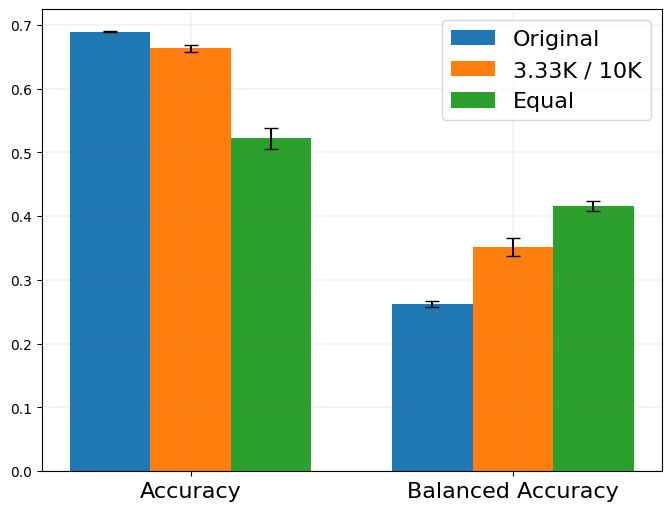

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

original_at, original_ef, original_in, original_nf = [], [], [], []
for eval in evaluations_original.values():
    original_ef.append(eval[2])
    original_in.append(eval[1])
original_means = {param: np.mean(values) for param, values in zip(['ef', 'in'], [original_ef, original_in])}
original_stds = {param: np.std(values) for param, values in zip(['ef', 'in'], [original_ef, original_in])}

horizontal_at, horizontal_ef, horizontal_in, horizontal_nf = [], [], [], []
for eval in evaluations_3_10.values():
    horizontal_ef.append(eval[2])
    horizontal_in.append(eval[1])
horizontal_means = {param: np.mean(values) for param, values in zip(['ef', 'in'], [horizontal_ef, horizontal_in])}
horizontal_stds = {param: np.std(values) for param, values in zip(['ef', 'in'], [horizontal_ef, horizontal_in])}

translation_at, translation_ef, translation_in, translation_nf = [], [], [], []
for eval in evaluations_equally.values():
    translation_ef.append(eval[2])
    translation_in.append(eval[1])
translation_means = {param: np.mean(values) for param, values in zip(['ef', 'in'], [translation_ef, translation_in])}
translation_stds = {param: np.std(values) for param, values in zip(['ef', 'in'], [translation_ef, translation_in])}

performance = np.array([[original_means['ef'], original_means['in']],
                        [horizontal_means['ef'], horizontal_means['in']],
                        [translation_means['ef'], translation_means['in']]])

std_dev = np.array([[original_stds['ef'], original_stds['in']],
                    [horizontal_stds['ef'], horizontal_stds['in']],
                    [translation_stds['ef'], translation_stds['in']]])

labels = ['Accuracy', 'Balanced Accuracy']
model_names = ['Original', '3.33K / 10K', 'Equal']
n_models = len(model_names)
n_labels = len(labels)

font_size = 16

x = np.arange(n_labels)  # positions of the labels
width = 0.25  # width of each bar, smaller to fit all models in each label group

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(n_models):
    ax.bar(x + i * width, performance[i], width, yerr=std_dev[i], label=model_names[i], capsize=5)

ax.set_xticks(x + width * (n_models - 1) / 2)  # Place the x-ticks in the middle of the grouped bars
ax.set_xticklabels(labels, fontsize=font_size)
ax.legend(fontsize=font_size, loc="best")
# ax.set_ylim(0.55)
# ax.set_ylabel("Area Under Curve (AUC)", fontsize=font_size)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# plt.savefig("evals/augmentation/geometricAll_20epochs_5runs_ES.pdf", bbox_inches='tight', pad_inches=0)

plt.show()